# <center>Módulo Machine Learning<center>

### Henrique Castro E Silva

### Enunciado

Escolha um notebook de um competidor de Kaggle que contenha um modelo de machine learning treinado (Não pegue nada que tenha Deep Learning), a partir dele você deve criar um seu criticando o que faria de melhorias no trabalho escolhido.

Além da análise entregar a sua versão desse modelo.

### Competição e notebooks escolhidos


A competicao escolhida foi a <a href="https://www.kaggle.com/c/spaceship-titanic/overview">Spaceship Titanic</a><br/>

Dentro delas diversos diferentes notebooks foram submetidos. Dentre eles eu escolhi analisar dois diferentes, apesar do enunciado pedir apenas um. Tomei essa decisao porque no primeiro notebook a analise ficara mais focada no preprocessamento de dados e no segundo no concepcao do modelo. 

O primeiro, que foi o mais votado dentro de todas as submissoes, se chama <a href="https://www.kaggle.com/code/odins0n/spaceship-titanic-eda-27-different-models/notebook">🚀Spaceship Titanic -📊EDA + 27 different models📈</a> que explora diferentes modelos. Por fazer o refinamento de um modelo que nao foi trabalhado no curso, eu escolhi utilizar esse notebook apenas para analisar o pre processamento de dados.

O segundo notebook se chama <a href="https://www.kaggle.com/code/meetnagadia/titanic-random-forest-score-0-79471">🚀 Titanic: Random Forest Score 0.79471</a>.

Ambos notebooks se encontram no diretorio <code>/notebook_analysis</code>

### Dados


>In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

O dataset foi divido em dois diferentes arquivos, um para teste e o outro para treino. Ambos se encontra no diretorio <code>/datasets</code>

Mais sobre os dados pode ser encontrado <a href="https://www.kaggle.com/c/spaceship-titanic/data">aqui</a>

In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score

In [2]:
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')

# Notebook 1 - EDA + 27 Models
O primeiro notebook apresenta uma analise detalhada e aprofundada do dataset, nao supreende ser o mais bem votado da competicao. Durante minha analise dele notei alguns, poucos, pontos que poderiam ser abordados de forma diferente possibilitando um POSSIVEL melhora.

## Lidando com NaN's

### Imputing

Para lidar com dados nulos o autor imputou valores numericos com a mediana. Para isso ele instancia a classe SimpleImputer, fita nos dados de treino e transforma dados de treino e teste.

Nesse momento existe uma pequena correção que podemos fazer. Ao inves de usar o mesmo SimpleImputer treinado em treino, podemos usar dois independentes, um para teste e um para treino, evitando carregar dados de um para outro.

Referencia: Celula executada 22

In [3]:
imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]

train[imputer_cols] = SimpleImputer(strategy='median').fit_transform(train[imputer_cols])
test[imputer_cols] = SimpleImputer(strategy='median').fit_transform(test[imputer_cols])

### Categoricos

Para as colunas categoricas, o autor usa o LabelEncoder sem antes tratar valores NaN. Por serem poucos, essa abordagem pode realmente ser a ideal, mas por mero capricho quis explorar um pouco mais os missing e tentar tratar algum.

As colunas categoricas sao **["HomePlanet", "CryoSleep","Cabin", "Destination" ,"VIP"]** 

Referencia: Celula executada 23

HomePlanet corresponde ao planeta de onde o passageiro saiu. Ao observar as features temos que a feature **PassengerId** e composta por dois numeros. O interessante a notar sao os 4 primeiros digitos, que segundo a descricao de dados _gggg indicates a group the passenger is travelling_ e que _People in a group are often family members, but not always_.

Tendo isso em vista, quis analisar se pessoas de um mesmo grupo sempre saem de um mesmo planeta

In [4]:
train['HomePlanet'].isna().sum()

201

In [5]:
train[['groupId','selfId']] = train['PassengerId'].str.split('_', 1, expand=True)
test[['groupId','selfId']] = test['PassengerId'].str.split('_', 1, expand=True)

In [6]:
train.groupby('groupId')['HomePlanet'].unique()

groupId
0001    [Europa]
0002     [Earth]
0003    [Europa]
0004     [Earth]
0005     [Earth]
          ...   
9275    [Europa]
9276    [Europa]
9278     [Earth]
9279     [Earth]
9280    [Europa]
Name: HomePlanet, Length: 6217, dtype: object

In [7]:
unique_homeplanet_train = train.groupby('groupId')['HomePlanet'].nunique()
unique_homeplanet_test = test.groupby('groupId')['HomePlanet'].nunique()
print(sum(np.where(unique_homeplanet_train > 1, 1, 0)))
print(sum(np.where(unique_homeplanet_test > 1, 1, 0)))

0
0


O codigo acima agrupa todos passageiros que estao no mesmo grupo e avalia se eles vieram do mesmo planeta. Como observado acima, em ambos test e treino, nao existe um grupo que possua pessoas que vieram de HomePlanet diferentes. Entao poderiamos imputar nos NaN's de HomePlanet o valor de outro membro do grupo. (Como nao possuimos ninguem de negocio, vou assumir que essa hipotese e valida)

In [8]:
train['HomePlanet'] = train.groupby('groupId')['HomePlanet'].apply(lambda x: x.ffill().bfill())

Apesar disso, so tiramos 90 NaN's e ainda nos restam outros NaN's nessa categoria 🙃🙃😅😅 mas pelo menos tentamos

In [9]:
train['HomePlanet'].isna().sum()

111

In [10]:
train["HomePlanet"].fillna('Z', inplace=True)
test["HomePlanet"].fillna('Z', inplace=True)

Tanto para essa coluna, quanto para as outras colunas categoricas poderiamos tentar usar outros metodos de imputing como o **KNNImputer**, mas como discutido em aula, isso poderia causar trazer um vies extra dentro do modelo. Entao acho que nao e necessario

### Encoding

Uma mini nota que vale observar e que no notebook original o autor utiliza do LabelEncoder para fazer encoding das features. Esse tipo de encoding nao e necessariamente o melhor tipo de encoding, dependendo do funcionamento do modelo que esta sendo usado. No modelo de RandomForest, que vamos analisar no proximo notebook, o uso de LabelEncoder e o mais adequado, porem como neste notebook estao sendo avalidos 27 modelos, para alguns essa forma de encoding os dados nao condiz, podendo acarretar em perda de performance

Referencia: Celula executada 23

In [11]:
label_cols = ["HomePlanet", "CryoSleep","Cabin", "Destination" ,"VIP"]
def label_encoder(train,test,columns):
    train[columns] = train[columns].astype(str)
    test[columns] = test[columns].astype(str)

    train[columns] = LabelEncoder().fit_transform(train[columns])
    test[columns] =  LabelEncoder().fit_transform(test[columns])
    
    return train, test

train ,test = label_encoder(train,test ,label_cols)

## Graficos

O autor durante a fase de EDA plota a distribuicao de dados entre as features categoricas. Ao fazer isso as cores dos graficos acabaram tornando um pouco confuso e os graficos nao ficaram "stackados", entao resolvi consertar esse grafico.

Referencia: Celula executada 18 e seu output

In [12]:
train['dataset'] = 'train'
test['dataset'] = 'test'
df = pd.concat([train, test])

In [13]:
train['CryoSleep'].value_counts()

0.0    5439
1.0    3037
2.0     217
Name: CryoSleep, dtype: int64

<AxesSubplot:xlabel='VIP'>

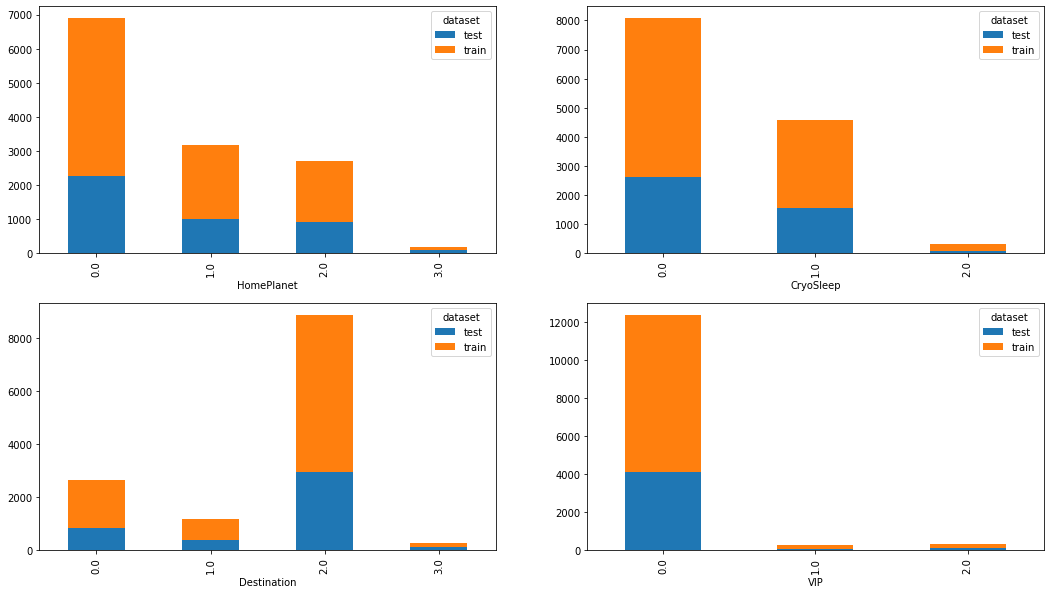

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

df.groupby(['HomePlanet', 'dataset']).size().reset_index()\
    .pivot(columns='dataset', index='HomePlanet', values=0).plot(kind='bar', stacked=True, ax=axes[0][0])

df.groupby(['CryoSleep', 'dataset']).size().reset_index()\
    .pivot(columns='dataset', index='CryoSleep', values=0).plot(kind='bar', stacked=True, ax=axes[0][1])

df.groupby(['Destination', 'dataset']).size().reset_index()\
    .pivot(columns='dataset', index='Destination', values=0).plot(kind='bar', stacked=True, ax=axes[1][0])

df.groupby(['VIP', 'dataset']).size().reset_index()\
    .pivot(columns='dataset', index='VIP', values=0).plot(kind='bar', stacked=True, ax=axes[1][1])

Enquanto fazia esses graficos, construi outra vizualização que também interessante observar

<AxesSubplot:xlabel='VIP', ylabel='VRDeck'>

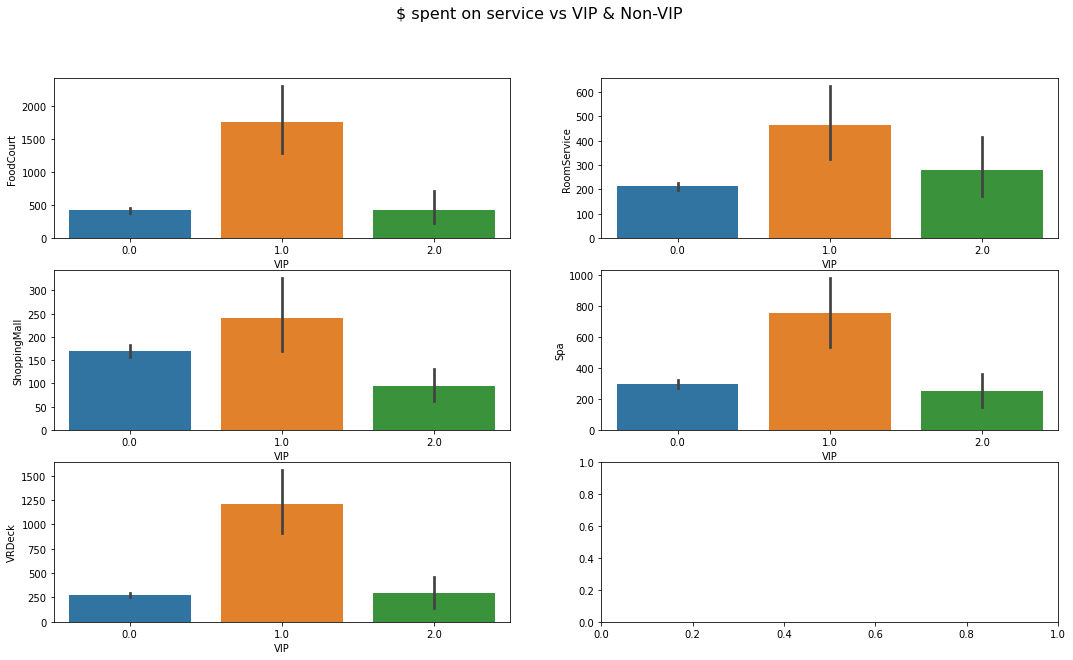

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(18, 10))

fig.suptitle("$ spent on service vs VIP & Non-VIP", fontsize=16)
sns.barplot(data = train, y='FoodCourt', x='VIP', ax=axes[0][0])
sns.barplot(data = train, y='RoomService', x='VIP', ax=axes[0][1])
sns.barplot(data = train, y='ShoppingMall', x='VIP', ax=axes[1][0])
sns.barplot(data = train, y='Spa', x='VIP', ax=axes[1][1])
sns.barplot(data = train, y='VRDeck', x='VIP', ax=axes[2][0])

# Notebook 2 - Random Forest Search
Esse notebook e uma continuacao de outro notebook do mesmo autor. Ele quebra os notebooks em duas partes, uma de EDA, que ao inves de analisar eu preferi ignorar uma vez que ja analisei um notebook de EDA, e a segunda metade que possui a criacao do modelo.

Para resolver o problema o autor utiliza do Random Forest, contudo ele nao faz a otimizao de hiperparametros nem feature selection, que talvez nesse caso por ter poucas features nao seja muito necessario. Nesse sessao vou implementar essas duas mudancas para ver se podemos ter ganhos

Outro ponto que vale mencionar e que o autor nao dropa a coluna PassengerID, que e uma indentiicacao unica do passageiro, portanto precisa ser dropada.

O autor tambem nao splita o X_train em X_val.

In [16]:
train = train.drop(columns=['groupId', 'selfId','dataset'])
test = test.drop(columns=['groupId', 'selfId','dataset'])

In [17]:
X_train = train.drop(columns=['Transported','PassengerId', 'Name', 'Cabin'])
y_train = np.where(train['Transported'], 1, 0)

In [37]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.7, random_state=42, stratify=y_train)

## Baseline

In [41]:
model = RandomForestClassifier(max_depth=10, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

accuracy_score(y_val, y_pred)

0.7948619631901841

## Feature Selection - Chi2

Abaixo vamos avaliar com a metrica de chi2, quais features podem ser mais interessantes para nosso modelo

In [18]:
fs = SelectKBest(score_func=chi2, k=5)
fs.fit(X_train, y_train)

SelectKBest(k=5, score_func=<function chi2 at 0x000001BABE3E61F8>)

In [35]:
for i, val in sorted([(i, val) for i, val in enumerate(fs.scores_)], key=lambda x: x[1], reverse=True):
	print('Feature %12s:\t%15f' % (X_train.columns[i], fs.scores_[i]))

Feature          Spa:	 1726733.192961
Feature       VRDeck:	 1573321.109084
Feature  RoomService:	 1002140.709290
Feature    FoodCourt:	  102562.057756
Feature ShoppingMall:	    1616.604682
Feature    CryoSleep:	    1033.372808
Feature          Age:	     342.173364
Feature   HomePlanet:	     104.956434
Feature  Destination:	      44.485285
Feature          VIP:	       2.831028


In [42]:
model_chi2 = RandomForestClassifier(max_depth=10, random_state=42)

X_train_chi2 = fs.transform(X_train)
X_val_chi2 = fs.transform(X_val)

model_chi2.fit(X_train_chi2, y_train)

y_pred = model_chi2.predict(X_val_chi2)
accuracy_score(y_val, y_pred)

0.7967791411042945

Usando as 5 melhores features do modelo, segundo o metodo de chi2, conseguimos aumentar a acuracia em 0.002, que nao e uma ganho muito consideravel mas ainda sim e algo.

## Hiperparameters tuning

In [43]:
espaco_hiperparametros ={
    'n_estimators': [10, 100, 200, 500],
    'max_depth' : [None, 5, 7, 10, 12, 15],
    'min_samples_split' : list(range(2, 10)),
    'min_samples_leaf': list(range(1,10))
}

In [44]:
model_hipertuning = RandomForestClassifier(random_state=42)

In [50]:
rand_search = RandomizedSearchCV(model_hipertuning, espaco_hiperparametros, n_iter=50, cv=3, verbose=10)
rand_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3; 1/50] START max_depth=15, min_samples_leaf=5, min_samples_split=3, n_estimators=100
[CV 1/3; 1/50] END max_depth=15, min_samples_leaf=5, min_samples_split=3, n_estimators=100;, score=0.791 total time=   0.4s
[CV 2/3; 1/50] START max_depth=15, min_samples_leaf=5, min_samples_split=3, n_estimators=100
[CV 2/3; 1/50] END max_depth=15, min_samples_leaf=5, min_samples_split=3, n_estimators=100;, score=0.797 total time=   0.3s
[CV 3/3; 1/50] START max_depth=15, min_samples_leaf=5, min_samples_split=3, n_estimators=100
[CV 3/3; 1/50] END max_depth=15, min_samples_leaf=5, min_samples_split=3, n_estimators=100;, score=0.785 total time=   0.3s
[CV 1/3; 2/50] START max_depth=12, min_samples_leaf=8, min_samples_split=3, n_estimators=10
[CV 1/3; 2/50] END max_depth=12, min_samples_leaf=8, min_samples_split=3, n_estimators=10;, score=0.786 total time=   0.0s
[CV 2/3; 2/50] START max_depth=12, min_samples_leaf=8, min_samples_split

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50,
                   param_distributions={'max_depth': [None, 5, 7, 10, 12, 15],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9],
                                        'n_estimators': [10, 100, 200, 500]},
                   verbose=10)

In [53]:
rand_search.best_params_

{'n_estimators': 100,
 'min_samples_split': 6,
 'min_samples_leaf': 8,
 'max_depth': None}

In [56]:
model_hipertunning = RandomForestClassifier(n_estimators=100, min_samples_split=6, min_samples_leaf=8, max_depth=None, random_state=42)

model_hipertunning.fit(X_train, y_train)

y_pred = model_hipertunning.predict(X_val)
accuracy_score(y_val, y_pred)

0.7979294478527608

## Hiperparam + Feature Selection

In [57]:
model_hipertunning = RandomForestClassifier(n_estimators=100, min_samples_split=6, min_samples_leaf=8, max_depth=None, random_state=42)

X_train_chi2 = fs.transform(X_train)
X_val_chi2 = fs.transform(X_val)

model_hipertunning.fit(X_train_chi2, y_train)

y_pred = model_hipertunning.predict(X_val_chi2)
accuracy_score(y_val, y_pred)

0.7983128834355828

## Conclusao
Usando os dois metodos acima, conseguimos um ganho de desempenho, nao muito grande, mas ainda sim consideravel.